# Jellyfish–Salinity Correlation

This notebook combines the cleaned datasets from the salinity and jellyfish exploration notebooks to quantify how surface salinity relates to jellyfish observations.

## Data sources
- **Salinity:** `woa18_decav_s00mn01.csv.gz` prepared in `salinity_data_exploration.ipynb` (surface layer of the World Ocean Atlas 2018 climatology).
- **Jellyfish:** `JeDI.csv` cleaned in `jellyfish_plankton_data_exploration.ipynb` (Jellyfish Database Initiative records).

Both files are expected under the repository `data/` directory. Update the paths below if you keep them elsewhere.

In [1]:
import math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')


In [2]:
# Configure input files
root = Path('data')
salinity_path = next((p for p in [root / 'woa18_decav_s00mn01.csv.gz', Path('../data/woa18_decav_s00mn01.csv.gz')] if p.exists()), None)
jellyfish_path = next((p for p in [root / 'JeDI.csv', Path('../data/JeDI.csv')] if p.exists()), None)

if salinity_path is None or jellyfish_path is None:
    raise FileNotFoundError('Expected salinity and jellyfish files were not found. Update the paths above.')

salinity_path, jellyfish_path


(PosixPath('data/woa18_decav_s00mn01.csv.gz'), PosixPath('data/JeDI.csv'))

In [5]:
import pandas as pd
import csv

# --- Detect separator (comma/semicolon/tab/pipe) ---
with open(salinity_path, 'r', encoding='utf-8', errors='ignore') as f:
    sample = f.read(4096)
try:
    dialect = csv.Sniffer().sniff(sample, delimiters=[',',';','\t','|'])
    sep = dialect.delimiter
except csv.Error:
    sep = ','

# --- Read with NO header; we'll interpret first row/col ourselves ---
raw = pd.read_csv(
    salinity_path,
    sep=sep,
    header=None,
    comment='#',
    engine='python',
    on_bad_lines='skip'
)

# Row 0 (from col 1 onward) = longitude headers
lon = pd.to_numeric(raw.iloc[0, 1:], errors='coerce').to_numpy()

# Col 0 (from row 1 downward) = latitude values
lat = pd.to_numeric(raw.iloc[1:, 0], errors='coerce').to_numpy()

# The data block = salinity values
vals = raw.iloc[1:, 1:]
vals = vals.apply(pd.to_numeric, errors='coerce')

# Build a proper DataFrame with labeled axes
grid = pd.DataFrame(vals.to_numpy(), index=lat, columns=lon)

# Tidy: (lat, lon, value)
salinity = (
    grid.stack().reset_index()
    .rename(columns={'level_0': 'lat', 'level_1': 'lon', 0: 'surface_salinity_psu'})
    .dropna(subset=['surface_salinity_psu'])
)

# Optional: aggregate to integer degree grid like you did
salinity['lat_round'] = salinity['lat'].round().astype(int)
salinity['lon_round'] = salinity['lon'].round().astype(int)
salinity = (
    salinity.groupby(['lat_round', 'lon_round'], as_index=False)['surface_salinity_psu']
            .mean()
)

print(salinity.head())


   lat_round  lon_round  surface_salinity_psu
0        -78       -178           -148.388889
1        -78         34             34.328641
2        -78         35             34.514842
3        -76       -178            -28.411392
4        -76         34             34.364816


In [6]:
# Load and clean jellyfish occurrence data
jellyfish = pd.read_csv(jellyfish_path)
jellyfish.columns = jellyfish.columns.str.strip().str.lower()

# Replace common missing value flags
jellyfish = jellyfish.replace({'nd': pd.NA, 'NA': pd.NA, '': pd.NA})

numeric_cols = [c for c in ['year', 'month', 'day', 'lat', 'lon',
                     'count_actual', 'density', 'density_integrated',
                     'biovolume', 'biovolume_integrated',
                     'weight_wet', 'weight_dry'] if c in jellyfish.columns]
for col in numeric_cols:
    jellyfish[col] = pd.to_numeric(jellyfish[col], errors='coerce')

if 'presence_absence' in jellyfish.columns:
    jellyfish = jellyfish[jellyfish['presence_absence'].astype(str).str.lower().eq('present')].copy()

if 'month' not in jellyfish.columns:
    jellyfish['month'] = 1
if 'day' not in jellyfish.columns:
    jellyfish['day'] = 1

jellyfish['date'] = pd.to_datetime(dict(year=jellyfish['year'],
                                         month=jellyfish['month'],
                                         day=jellyfish['day']
                                        ), errors='coerce')
jellyfish = jellyfish.dropna(subset=['lat', 'lon'])
jellyfish['lat_round'] = jellyfish['lat'].round().astype(int)
jellyfish['lon_round'] = jellyfish['lon'].round().astype(int)

date_range = jellyfish['date'].agg(['min', 'max'])
date_range


/tmp/ipykernel_13936/820917662.py:2: DtypeWarning: Columns (7,8,22,23,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  jellyfish = pd.read_csv(jellyfish_path)


min   1871-07-01
max   2011-09-03
Name: date, dtype: datetime64[ns]

In [7]:
# Aggregate jellyfish metrics by 1°×1° cell
value_cols = [c for c in ['count_actual', 'density', 'density_integrated',
                     'biovolume', 'biovolume_integrated',
                     'weight_wet', 'weight_dry'] if c in jellyfish.columns]
aggregations = {col: 'mean' for col in value_cols}
aggregations['date'] = 'count'
aggregated = jellyfish.groupby(['lat_round', 'lon_round']).agg(aggregations).rename(columns={'date': 'record_count'})
aggregated = aggregated.reset_index()
aggregated.head()


,lat_round,lon_round,count_actual,density,density_integrated,biovolume,biovolume_integrated,weight_wet,weight_dry,record_count
0,-78,-173,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1
1,-78,-166,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1
2,-78,-165,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1
3,-78,-164,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1
4,-78,166,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1


In [8]:
# Merge with salinity
merged = pd.merge(aggregated, salinity, on=['lat_round', 'lon_round'], how='inner')
print(f'Merged cells: {len(merged)}')
merged.head()


Merged cells: 21


,lat_round,lon_round,count_actual,density,density_integrated,biovolume,biovolume_integrated,weight_wet,weight_dry,record_count,surface_salinity_psu
0,-66,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,34.552811
1,-62,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,34.585868
2,-42,-178,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,2,-39.750000
3,-36,34,14.000000,0.02925,5.8550,NaN,NaN,NaN,NaN,7,34.859074
4,-36,35,2.666667,0.01060,2.1174,NaN,NaN,NaN,NaN,11,34.879111


In [9]:
# Compute Pearson correlations
numeric_for_corr = merged.select_dtypes(include='number')
corr = numeric_for_corr.corr(method='pearson')
corr


,lat_round,lon_round,count_actual,density,density_integrated,biovolume,biovolume_integrated,weight_wet,weight_dry,record_count,surface_salinity_psu
lat_round,1.000000,-0.236470,-0.117416,0.008387,0.091121,NaN,NaN,NaN,NaN,0.234978,-0.259979
lon_round,-0.236470,1.000000,0.302763,0.095992,0.013240,NaN,NaN,NaN,NaN,0.134263,0.911771
count_actual,-0.117416,0.302763,1.000000,0.976518,0.955431,NaN,NaN,NaN,NaN,0.104258,0.259537
density,0.008387,0.095992,0.976518,1.000000,0.996566,NaN,NaN,NaN,NaN,-0.235953,0.116541
density_integrated,0.091121,0.013240,0.955431,0.996566,1.000000,NaN,NaN,NaN,NaN,-0.278048,0.033920
biovolume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
biovolume_integrated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight_wet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight_dry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
record_count,0.234978,0.134263,0.104258,-0.235953,-0.278048,NaN,NaN,NaN,NaN,1.000000,0.117079


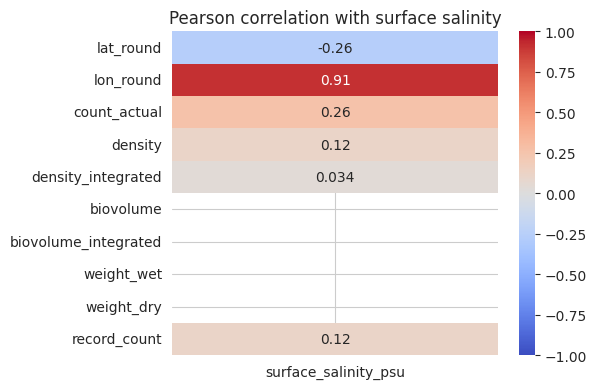

In [10]:
# Visualise correlations with salinity
plt.figure(figsize=(6,4))
sns.heatmap(corr[['surface_salinity_psu']].drop(index=['surface_salinity_psu']),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pearson correlation with surface salinity')
plt.tight_layout()
plt.show()


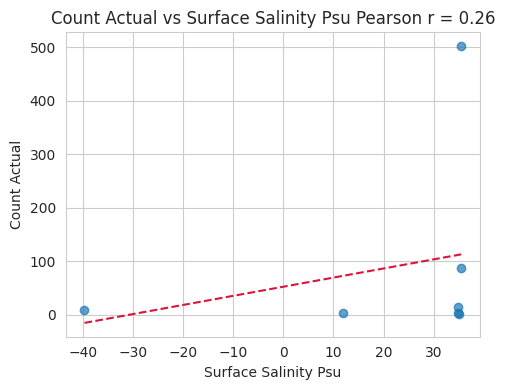

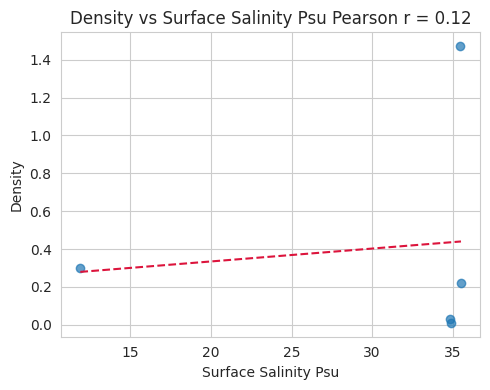

Skipping biovolume – not enough data after merging.


In [11]:
# Scatter plots for key variables
def scatter_with_fit(df, x_col, y_col):
    data = df[[x_col, y_col]].dropna()
    if len(data) < 3:
        print(f'Skipping {y_col} – not enough data after merging.')
        return
    m, b = np.polyfit(data[x_col], data[y_col], 1)
    xp = np.linspace(data[x_col].min(), data[x_col].max(), 100)
    yp = m * xp + b
    r = data[x_col].corr(data[y_col])

    plt.figure(figsize=(5,4))
    plt.scatter(data[x_col], data[y_col], alpha=0.7)
    plt.plot(xp, yp, '--', color='crimson')
    plt.xlabel(x_col.replace('_', ' ').title())
    plt.ylabel(y_col.replace('_', ' ').title())
    plt.title(f'{y_col.replace('_', ' ').title()} vs {x_col.replace('_', ' ').title()} Pearson r = {r:.2f}')
    plt.tight_layout()
    plt.show()

for target in ['count_actual', 'density', 'biovolume']:
    col = f'{target}' if target in merged.columns else None
    if col and col in merged:
        scatter_with_fit(merged, 'surface_salinity_psu', col)


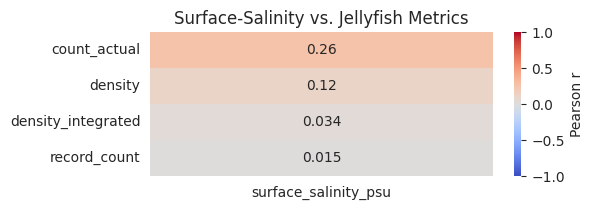

In [13]:
# ----------------------------------------------
# JELLYFISH-SALINITY CORRELATION HEAT-MAP
# ----------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# 1) sane salinity range
merged = merged[(merged["surface_salinity_psu"] > 0) &
                (merged["surface_salinity_psu"] < 42)]

# 2) keep jellyfish metrics that have at least three overlaps with salinity
min_pairs = 3
numeric_cols  = merged.select_dtypes("number").columns
jelly_metrics = [c for c in numeric_cols
                 if c not in ("lat_round", "lon_round", "surface_salinity_psu")]

good_vars = [c for c in jelly_metrics
             if merged[["surface_salinity_psu", c]].dropna().shape[0] >= min_pairs]

# 3) build & plot the matrix
corr = merged[["surface_salinity_psu"] + good_vars].corr(method="pearson")

plt.figure(figsize=(6, 0.6 + 0.4 * len(good_vars)))
sns.heatmap(corr[["surface_salinity_psu"]].loc[good_vars],
            annot=True, cmap="coolwarm", vmin=-1, vmax=1,
            cbar_kws={"label": "Pearson r"})
plt.title("Surface-Salinity vs. Jellyfish Metrics")
plt.ylabel("")        # tidy vertical axis
plt.tight_layout()
plt.show()
